# Computation of North Westerly winds

## Preamble

### Imports

In [33]:
import cdsapi
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt

from matplotlib_inline.backend_inline import set_matplotlib_formats

### Pre-sets

In [41]:
# Matplotlib settings
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['svg.fonttype'] = 'none'
set_matplotlib_f ormats('retina')
plt.rcParams['figure.dpi'] = 300
# Plotnine settings (for figures)

p9.options.set_option('base_family', 'Georgia')

p9.theme_set(
    p9.theme_bw()
    + p9.theme(panel_grid=p9.element_blank(),
               legend_background=p9.element_blank(),
               panel_grid_major=p9.element_line(size=.5, linetype='dashed',
                                                alpha=.15, color='black'),
               dpi=300
    )
)

## Main code

This code excerpt was generated to respond reviewer #2 during the revision of this
manuscript on Environmental Research Letters. The reviewer asked us to provide
information on the historical wind patterns in the region of interest. 

We downloaded the ERA5 reanalysis data for winds in Tokyo and Kumamoto, two of the relevant
regions in the manuscript. We downloaded monthly wind direction and speed for those 
locations and then computed the north-westerly component of the wind.

We define a couple of functions to download the data from the Copernicus Climate Data Store and compute
the north-westerly component of the wind.

In [1]:

def download_wind_data(city, lat, lon, filename):

    years = [str(year) for year in range(1996, 2020 + 1)]

    c.retrieve(
        "reanalysis-era5-single-levels-monthly-means",
        {
            "product_type": "monthly_averaged_reanalysis",
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
            ],
            "year": years,
            "month": [
                "01", "02", "03", "04", "05", "06",
                "07", "08", "09", "10", "11", "12"
            ],
            "time": "00:00",
            "grid": [0.25, 0.25],
            "area": [lat - .01 , lon - .01, lat, lon],
            "format": "netcdf",
        },
        filename
    )

def add_nw_wind(data):
    angle_rad = np.radians(45)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)

    nw_wind = cos_angle * data['u10'] - sin_angle * data['v10']
    data_copy = data.copy()
    data_copy['nw_wind'] = nw_wind
    return data_copy

We then use those functions to download the data and compute the north-westerly component of the wind
for each location for the period 1996 to 2020:

In [ ]:

# Download data
kumamoto_lat, kumamoto_lon = 32.79, 130.74
download_wind_data("Kumamoto", kumamoto_lat, kumamoto_lon, "kumamoto_wind_data.nc")

tokyo_lat, tokyo_lon = 35.68, 139.76
download_wind_data("Tokyo", tokyo_lat, tokyo_lon, "tokyo_wind_data.nc")

# Load data and add NW-wind variable
kumamoto_data = xr.open_dataset("kumamoto_wind_data.nc")
kumamoto_data = add_nw_wind(kumamoto_data)

tokyo_data = xr.open_dataset("tokyo_wind_data.nc")
tokyo_data = add_nw_wind(tokyo_data)

And plot the results:

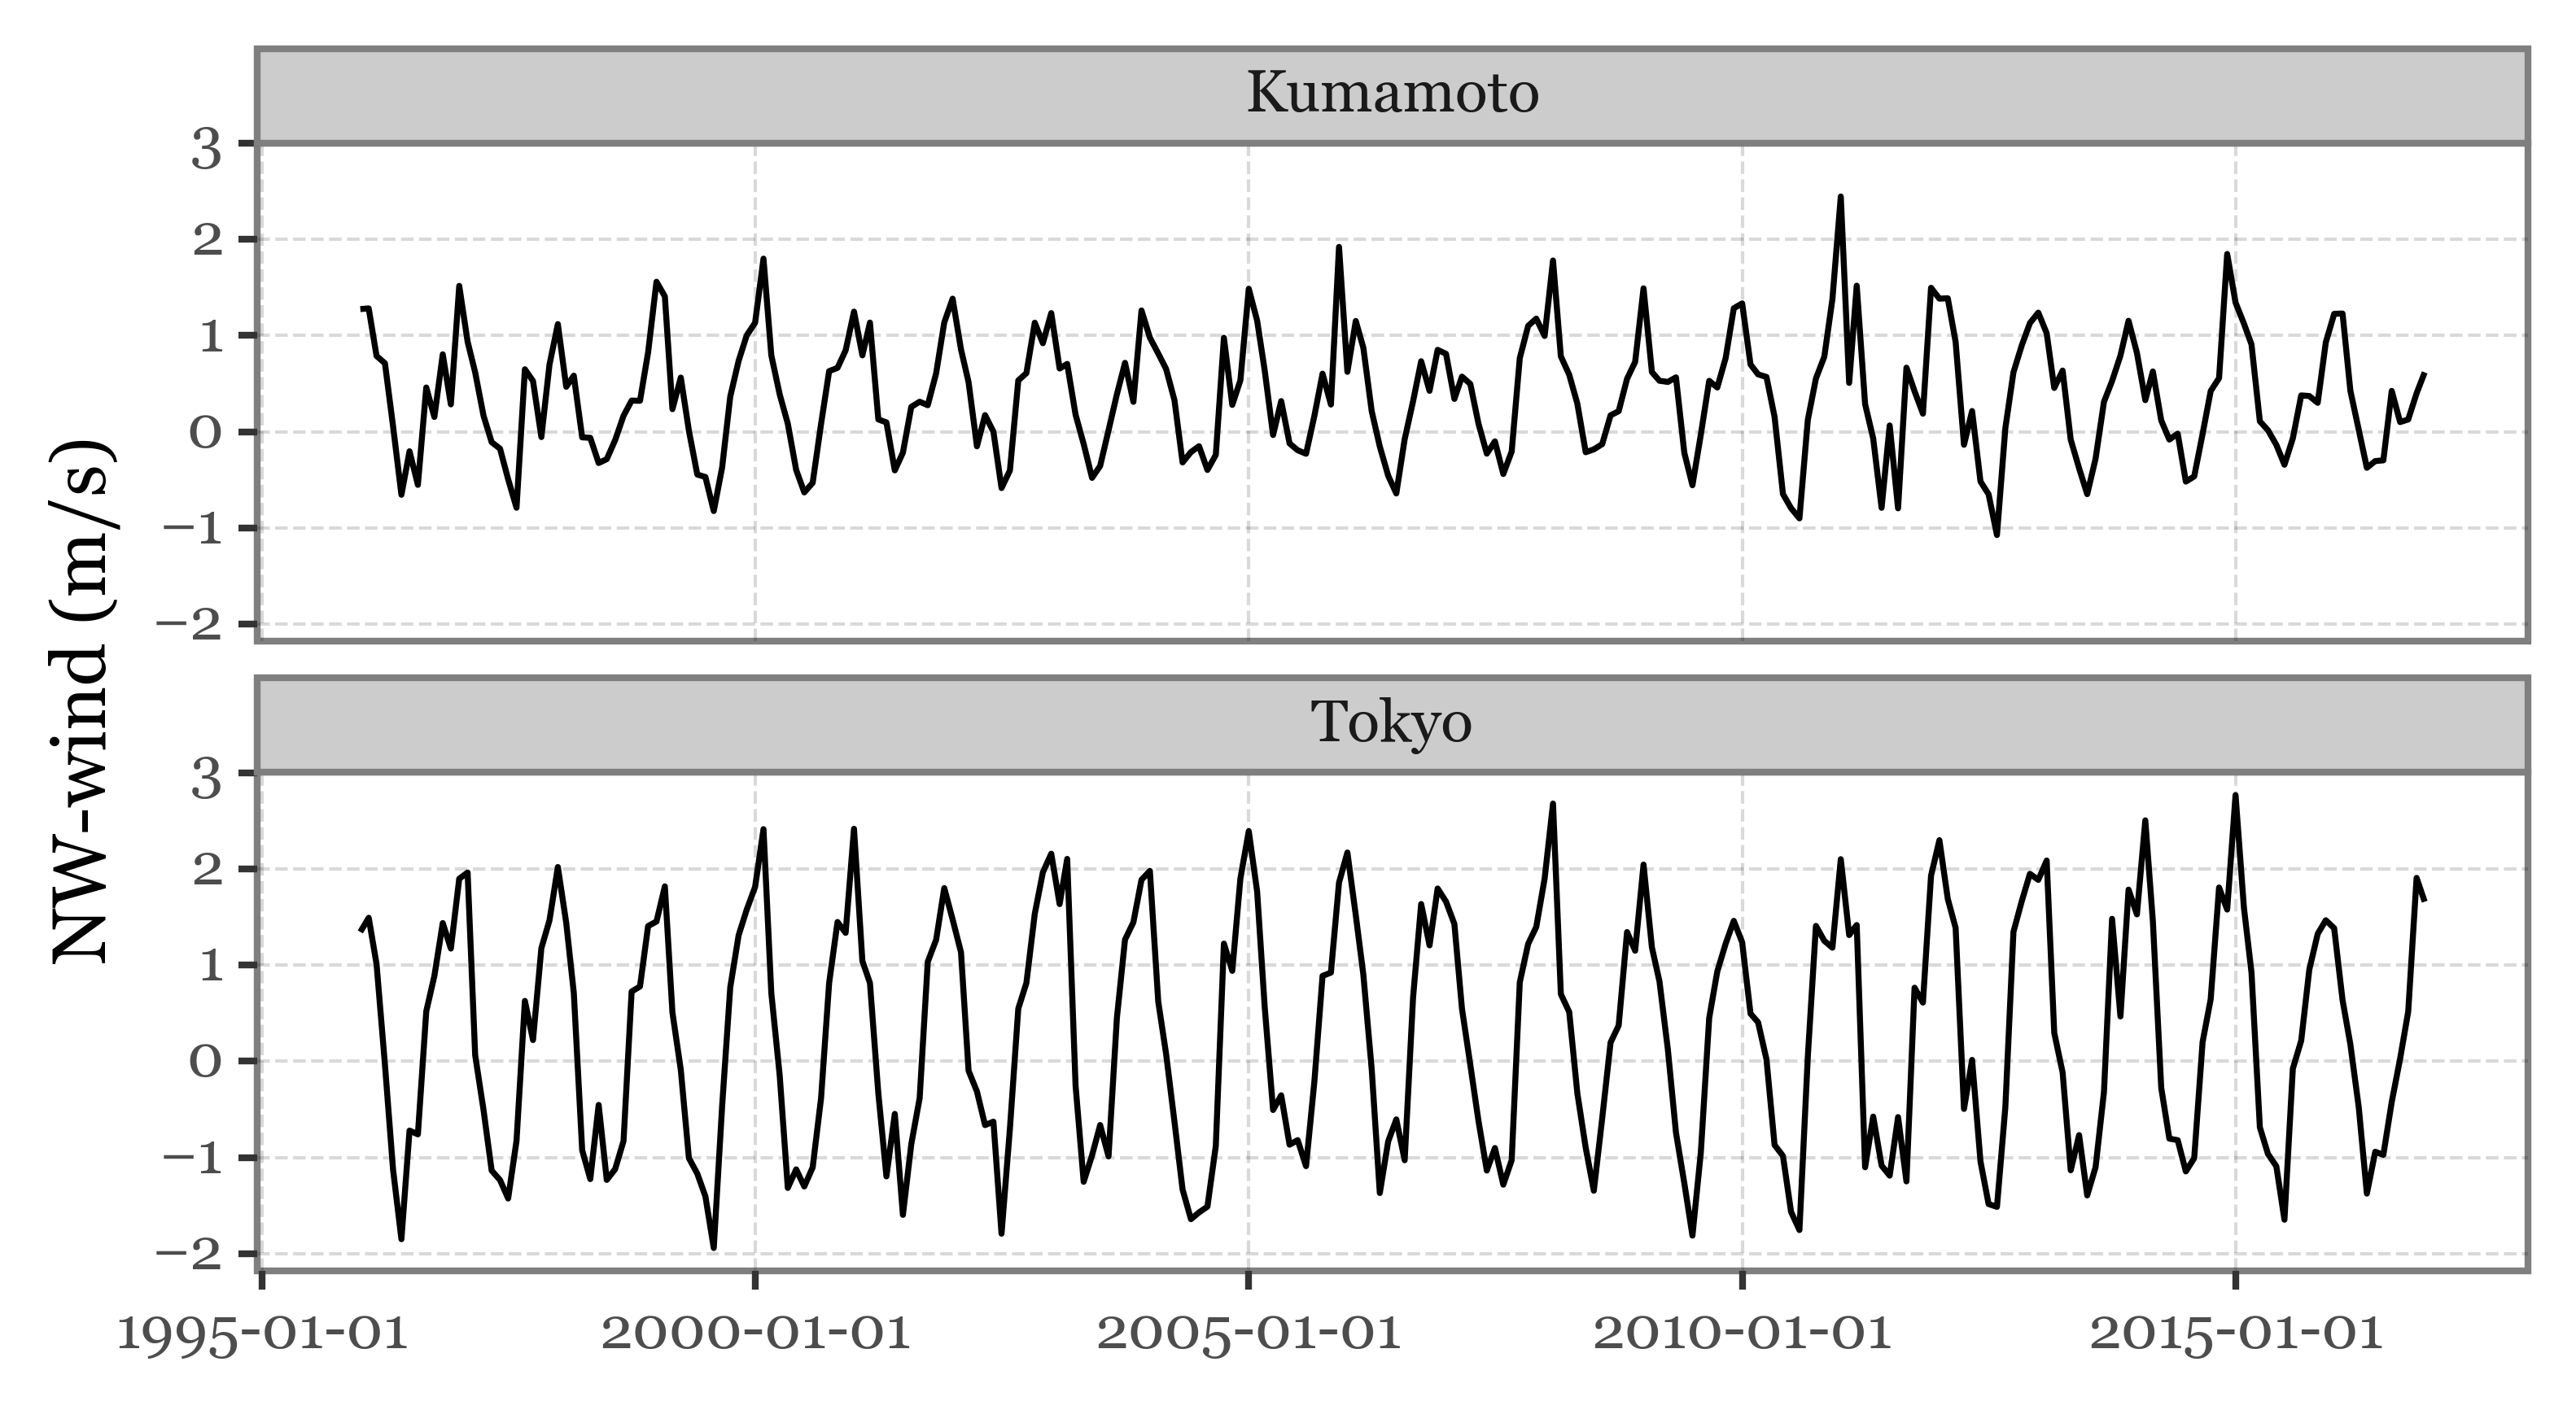

<ggplot: (752024958)>

In [133]:
(pd.concat([tokyo_data
    .to_dataframe()
    .groupby('time')
    ['nw_wind']
    .mean()
    .reset_index()
    .assign(location='Tokyo'),
    (kumamoto_data
    .to_dataframe()
    .groupby('time')
    ['nw_wind']
    .mean()
    .reset_index()
    .assign(location='Kumamoto'))])
    .query('time < "2017"')
 .pipe(lambda dd: p9.ggplot(dd)
     + p9.aes(x='time', y='nw_wind')
     + p9.geom_line()
     + p9.facet_wrap('~location', ncol=1)
     + p9.theme(figure_size=(6, 3))
     + p9.labs(x='', y='NW-wind (m/s)')
 )
)
